In [1]:
## setup

# numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
import cmasher as cmr

def stylize_plot(axis, xlab, ylab, labelsize=14, ticksize=12, hide=["right","top"], ticks = {"top":False,"bottom":True,"left":True,"right":False}):
        if hide:
                for h in hide:
                        axis.spines[h].set_visible(False)
                        ticks[h] = False

        axis.tick_params(which='minor', length=2, direction="in", top=ticks["top"], bottom=ticks["bottom"], left=ticks["left"], right=ticks["right"], labelsize=ticksize)
        axis.tick_params(which='major', length=4, direction="in", top=ticks["top"], bottom=ticks["bottom"], left=ticks["left"], right=ticks["right"], labelsize=ticksize)

        axis.set_ylabel(ylab,size=labelsize)
        axis.set_xlabel(xlab,size=labelsize)      
        return
    
COLOR_GRADIENT = {"K0,0.1":"xkcd:pale cyan", "K0,0.2":"xkcd:bright sky blue", "K0,0.3":"xkcd:azure", "K0,0.6":"xkcd:azul", "K0,1.0":"xkcd:cobalt blue",
                "K1,0.1":"xkcd:pale gold", "K1,0.2":"xkcd:golden yellow", "K1,0.3":"xkcd:yellowish orange", "K1,0.6":"xkcd:pumpkin orange", "K1,1.0":"xkcd:dark orange",
                "K2,0.1":"xkcd:rosa", "K2,0.2":"xkcd:warm pink", "K2,0.3":"xkcd:dark hot pink", "K2,0.6":"xkcd:dark magenta", "K2,1.0":"xkcd:merlot",
                "K5,0.1":"xkcd:seafoam", "K5,0.2":"xkcd:seaweed", "K5,0.3":"xkcd:seaweed green", "K5,0.6":"xkcd:dark sea green", "K5,1.0":"xkcd:spruce",
                "50,0.3":"xkcd:silver", "50,0.6":"xkcd:gray", "50,1.0":"xkcd:black",
                "100,0.3":"xkcd:butteryellow", "100,0.6":"xkcd:butterscotch", "100,1.0":"xkcd:caramel",
                "300,0.3":"xkcd:lavender", "300,0.6":"xkcd:plum", "300,1.0":"xkcd:plum"}

# load Roboto-Regular to set as font
from matplotlib import font_manager
path_font = [ f for f in font_manager.findSystemFonts(fontpaths=os.getcwd(), fontext="ttf") if "Roboto-Regular" in f][0]
font = font_manager.FontEntry(fname=str(path_font), name="Roboto-Regular")
font_manager.fontManager.ttflist.append(font)

# define font sizes
SIZE_DEFAULT = 10
SIZE_LARGE = 12
plt.rc("font", family=font.name)  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

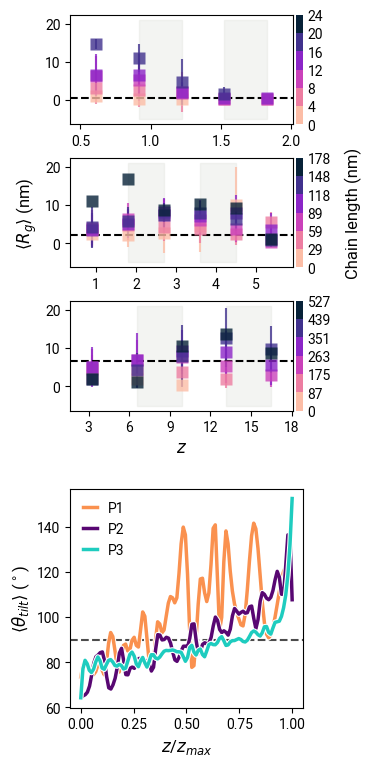

In [2]:
# Fig 4

def make_colormap(cmap, ngroups):
    colors_dens = cmap(np.linspace(0, 1, ngroups))
    bounds = np.arange(len(colors_dens)+1)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    return colors_dens, sm

from scipy.interpolate import make_interp_spline

colors_tilt, sm_tilt = make_colormap(cmr.guppy, 3)
colors_Rg, sm_Rg = make_colormap(cmr.bubblegum_r, 6)


ROOT = os.getcwd()
NREPS = ["K0","K2","K5"]
SAMPLE = {"K0":"P1", "K2":"P2", "K5":"P3"}


fig,axes = plt.subplots(5,1, figsize=(3,9), gridspec_kw={"height_ratios":(1,1,1,0.1,2),"hspace":0.3})
axes[-2].set_axis_off()

jj = 0
cbars = []
axes_Rg = axes[:-2]
for NREP,ax in zip(NREPS,axes_Rg):

    Rgs = pd.read_csv(f"{ROOT}/roughness/Rg_layers_{NREP}.csv")
    Lcuts = Rgs["lengths"].unique()
    Rgs = Rgs[(Rgs["dens"] == 0.3) & (Rgs["run"]=="run1")]
    Zcuts = Rgs["z"].unique()

    grouped = Rgs.groupby("z")
    colors = {int(Lcuts[i]):colors_Rg[i] for i in range(len(colors_Rg))}
    ax.set_xlim(Zcuts[0]-Zcuts[-1]*.1, Zcuts[-1]+Zcuts[-1]*.1)

    Rg_avs = []
    for i,group in grouped:
        print
        subgroups = group[["z","lengths","dens","Rg"]].groupby("lengths")
        j = 0
        avgs = []
        for k, subgroup in subgroups:
            L = subgroup["lengths"].mean()
            ax.errorbar(subgroup["z"].mean(), subgroup["Rg"].mean(), subgroup["Rg"].std(), color=colors[int(L)], marker="s", mec="none", ms=8, alpha=0.8)
            
            avgs.append(subgroup["Rg"].mean())
            j += 1

        Rg_av = np.mean(avgs)
        Rg_avs.append(Rg_av)

    ax.axhline(y=Rg_avs[-1], c="k", ls="dashed")
    ax.fill_betweenx([-5,21], Zcuts[1], Zcuts[2], alpha=0.3, color="xkcd:light gray", zorder=-2)
    ax.fill_betweenx([-5,21], Zcuts[3], Zcuts[4], alpha=0.3, color="xkcd:light gray", zorder=-2)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size="3%", pad=0.03)
    cbar = fig.colorbar(sm_Rg, ax=ax, cax=cax, orientation='vertical', location="right", ticks=np.linspace(0, 6, 6+1))
    cbar.ax.set_yticklabels([0]+[int(l) for l in Lcuts[:]], ha='left')
    cbar.ax.tick_params(which='both', size=0)
    cbar.outline.set_edgecolor('none')
    cbars.append(cbar)

cbars[1].ax.set_ylabel("Chain length (nm)", labelpad=10)
axes_Rg[0].set_xticks([0.5,1,1.5,2])
axes_Rg[1].set_xticks([1,2,3,4,5])
axes_Rg[2].set_xticks([3,6,9,12,15,18])
axes_Rg[-1].set_xlabel("$z$")
axes_Rg[1].set_ylabel("$\\langle R_g \\rangle$ (nm)")

ax_tilt = axes[-1]
jj = 0
for NREP in NREPS:

    tilts = pd.read_csv(f"{ROOT}/tilt_angles/tilt_angles_{NREP}.csv")
    group = tilts[["idx","z","theta"]].groupby("idx").mean()

    f = make_interp_spline(group["z"], group["theta"])
    ax_tilt.plot(group["z"]/group["z"].max(), group["theta"], color="white", ls="solid", lw=4.0, zorder=1)
    ax_tilt.plot(group["z"]/group["z"].max(), group["theta"], color=colors_tilt[jj], ls="solid", lw=2.5, zorder=1, label=SAMPLE[NREP])

    jj += 1

ax_tilt.legend(frameon=False, loc="upper left", handlelength=1)
ax_tilt.axhline(90, c="k", ls="dashed", alpha=0.7, zorder=0)
ax_tilt.set_xlabel("$z$/$z_{max}$")
ax_tilt.set_ylabel("$\\langle \\theta_{tilt} \\rangle$ ($^\circ$)")
 
fig.savefig(f"{ROOT}/plots/Fig4_part2.png", dpi=400, bbox_inches="tight")
fig.savefig(f"{ROOT}/plots/Fig4_part2.svg", dpi=400, bbox_inches="tight")